In [1]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [2]:
import time
import numpy as np
import random as random
from scipy.special import softmax
import math
import pandas as pd
from matplotlib import pyplot as plt

class Network():
    
    # Utils
    
    def __generate_random_matrix(self, shape_x, shape_y, max_value=1):
        return np.random.rand(shape_x, shape_y) * 2 * max_value - max_value
    
    def __generate_random_number(self, max_value=0.1):
        return random.random() * 2 * max_value - max_value
    
    # Constructor
    
    def __init__(self, layer_shapes, function, max_value=1, method='random'):
        self.weights = []
        self.biases = []
        self.function = function
        
        for i, layer_shape in enumerate(layer_shapes):
            shape_x, shape_y = layer_shape
            
            var = 0
            
            if method == 'xavier':
                var = 2.0 / (layer_shapes[i][0] + layer_shapes[i][1])
                w = np.random.normal(0, var, size=(shape_x, shape_y))
                self.weights.append(w)
            elif method == 'he':
                var = 2.0 / layer_shapes[i][0]
                w = np.random.normal(0, var, size=(shape_x, shape_y))
                self.weights.append(w)
            else:
                self.weights.append(self.__generate_random_matrix(shape_x, shape_y, max_value=max_value))
                
            self.biases.append(self.__generate_random_number())
        
    # Code
    
    @staticmethod
    def normalize(X):
        return X / 254
    
    @staticmethod
    def get_result(prediction):
        return np.where(prediction == np.max(prediction))[0][0]
    
    def __sigmoid(self, z, deriv=False):
        if deriv:
            sigmoid = self.__sigmoid(z)
            return sigmoid * (1 - sigmoid)
        else:
            return 1.0 / (1.0 + np.exp(-z))
        
    def __tangens(self, z, deriv=False):
        if deriv:
            tangens = self.__tangens(z)
            return tangens * (1 - tangens)
        else:
            return (2 / (1 + np.exp(-2 * z))) - 1
        
    def __relu(self, z, deriv=False):
        if deriv:
            return 1 / (1 + np.exp(-z / np.max(z))) if np.mean(z) > 1000 else 1 / (1 + np.exp(-z))
        else:
            return np.log(1 + np.exp(z / np.max(z))) if np.mean(z) > 1000 else np.log(1 + np.exp(z))
        
    def __activation_function(self, z, deriv=False):
        if self.function == 'sigmoid':
            return self.__sigmoid(z, deriv)
        elif self.function == 'tangens':
            return self.__tangens(z, deriv)
        else:
            return self.__relu(z, deriv)
    
    def __softmax_derivative(self, x):
        return softmax(x) * (1 - softmax(x))
    
    def forward(self, X, predict=False):
        
        aa = [X]
        zz = [X]
        a = X
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = a @ w + b
            
            if i == len(self.weights) - 1:
                a = softmax(z, axis=1)
            else:
                a = self.__activation_function(z)
                
            aa.append(a)
            zz.append(z)
            
        if predict:
            return a
        else:
            return aa, zz
        
    def backpropagation(self, y, aa, zz):
        
        cost = np.sum((y - aa[-1]) ** 2) / 2
    
        deltas = []
        errors = []
        output_error = y - aa[-1]
        errors.append(output_error)
        
        delta = output_error * self.__softmax_derivative(aa[-1])
        deltas.append(delta)
        
        for i in range(1, len(aa) - 1):
            hidden_error = delta @ self.weights[-i].T
            errors.append(hidden_error)
            delta = hidden_error * self.__activation_function(aa[-(i + 1)], True)
            deltas.append(delta)
        
        return cost, deltas, errors
    
    def train(self, X, y, learning_rate, batch_size, max_epochs, max_error):
    
        costs = []
        batch_index = 0
        epochs = 0
        
        vt1 = [0] * len(self.weights)
        
        for i in range(max_epochs):
            
            batch_X = X[batch_index * batch_size:(batch_index + 1) * batch_size]
            batch_y = y[batch_index * batch_size:(batch_index + 1) * batch_size]
            batch_index += 1
            
            if batch_index * batch_size >= len(X):
                batch_index = 0
            
            aa, zz = self.forward(batch_X)
            cost, deltas, errors = self.backpropagation(batch_y, aa, zz)

            for j in range(len(self.weights)):
                self.weights[j] += learning_rate * aa[j].T @ deltas[-(j + 1)]
                self.biases[j] += learning_rate * np.mean(deltas[-(j + 1)])

            costs.append(cost)
            
            epochs += 1
            
            if (cost / batch_size < max_error):
                break

#             if i % 1000 == 0:
#                 print(f'Iteration: {i}, error: {cost / batch_size}')
                
        return costs, epochs

Epochs: 10000


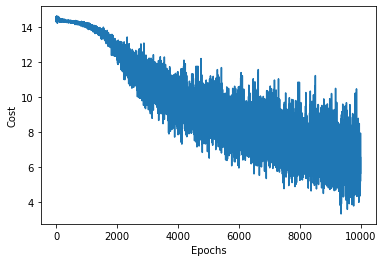

In [17]:
layer_shapes=[(784, 15), (15, 10)]

network = Network(layer_shapes=layer_shapes, function='sigmoid', method='xavier')

X = []
for X_matrix in train_X:
    X.append(Network.normalize(X_matrix.reshape(784)))
X = np.array(X)
    
labels = []
for y in train_y:
    label = np.zeros(10)
    label[y] = 1
    labels.append(label)
labels = np.array(labels)

costs, epochs = network.train(X, 
              labels, 
              learning_rate=0.1, 
              max_epochs=10000,
              batch_size=32,
              max_error=0.05)

print(f'Epochs: {epochs}')

plt.plot(costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

In [18]:
X = []
for X_matrix in test_X:
    X.append(Network.normalize(X_matrix.reshape(784)))
X = np.array(X)

z = network.forward(X, predict=True)

sum = 0
for z_i, label_i in zip(z, test_y):
    if Network.get_result(z_i) == label_i:
        sum +=1
        
print(f'Accuracy: {round(sum / len(z) * 100, 2)}%')

Accuracy: 73.92%
